In [1]:
%matplotlib inline

import warnings
from datetime import datetime
import os
from pathlib import Path
import quandl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
from pyfinance.ols import PandasRollingOLS
from sklearn.feature_selection import mutual_info_classif

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

In [3]:
with pd.HDFStore('../../data/data.h5') as store:
    data = store['engineered_features']

## Create Dummy variables

In [4]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 445640 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-02-28 00:00:00)
Data columns (total 89 columns):
return_1m                445640 non-null float64
return_2m                445640 non-null float64
return_3m                445640 non-null float64
return_6m                445640 non-null float64
return_9m                445640 non-null float64
return_12m               445640 non-null float64
CMA                      445640 non-null float64
HML                      445640 non-null float64
Mkt-RF                   445640 non-null float64
RMW                      445640 non-null float64
SMB                      445640 non-null float64
momentum_2               445640 non-null float64
momentum_3               445640 non-null float64
momentum_6               445640 non-null float64
momentum_9               445640 non-null float64
momentum_12              445640 non-null float64
momentum_3_12            445640 non-null float64
return_1m_t-

## Mutual Information

### Original Data

In [5]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [6]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [7]:
mutual_info.sum()

target_1m     0.053056
target_2m     0.079370
target_3m     0.102913
target_6m     0.156282
target_12m    0.221293
dtype: float64

### Normalized MI Heatmap

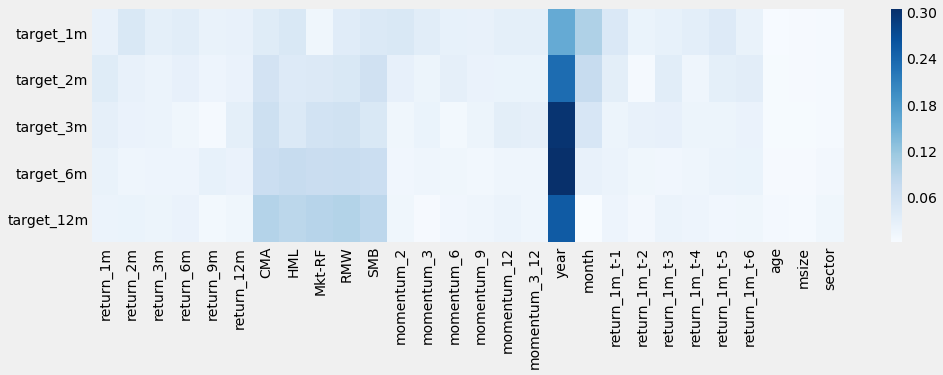

In [8]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

### Dummy Data

In [9]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [10]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [11]:
mutual_info_dummies.sum()

target_1m     0.054261
target_2m     0.081427
target_3m     0.105798
target_6m     0.160603
target_12m    0.226720
dtype: float64

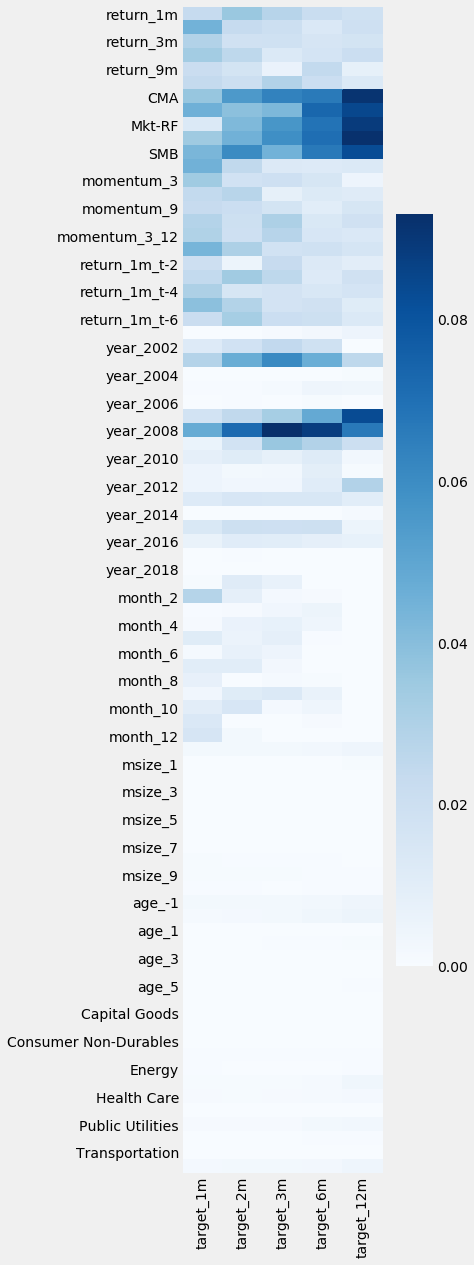

In [12]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');